**Кольцов Кирилл Евгеньевич, группа 209**

В качестве модели для соревнования было принято решение реализовать **ALGNet** - сверточную нейросеть, [представленную](https://arxiv.org/pdf/2403.20106v2) 5 апреля 2024 года Hu Gao и Depeng Dang. 

Модель берёт за основу форму U, вместе с `skip connections`, `downsampling`'ом и `upsampling`'ом. Всё это реализовано в базовой части задания: используются соответственно `GeneralizedUNet`, `NAFNetUpBlock`, `NAFNetDownBlock`. Интерес представляет `ALGBlock`. Единственное, в реализацию `GeneralizedUNet` была дописана возможность добавления сверточных слоёв непосредственно перед `ALGBlock`, так как этого требует изначальная архитектура, показанная ниже:

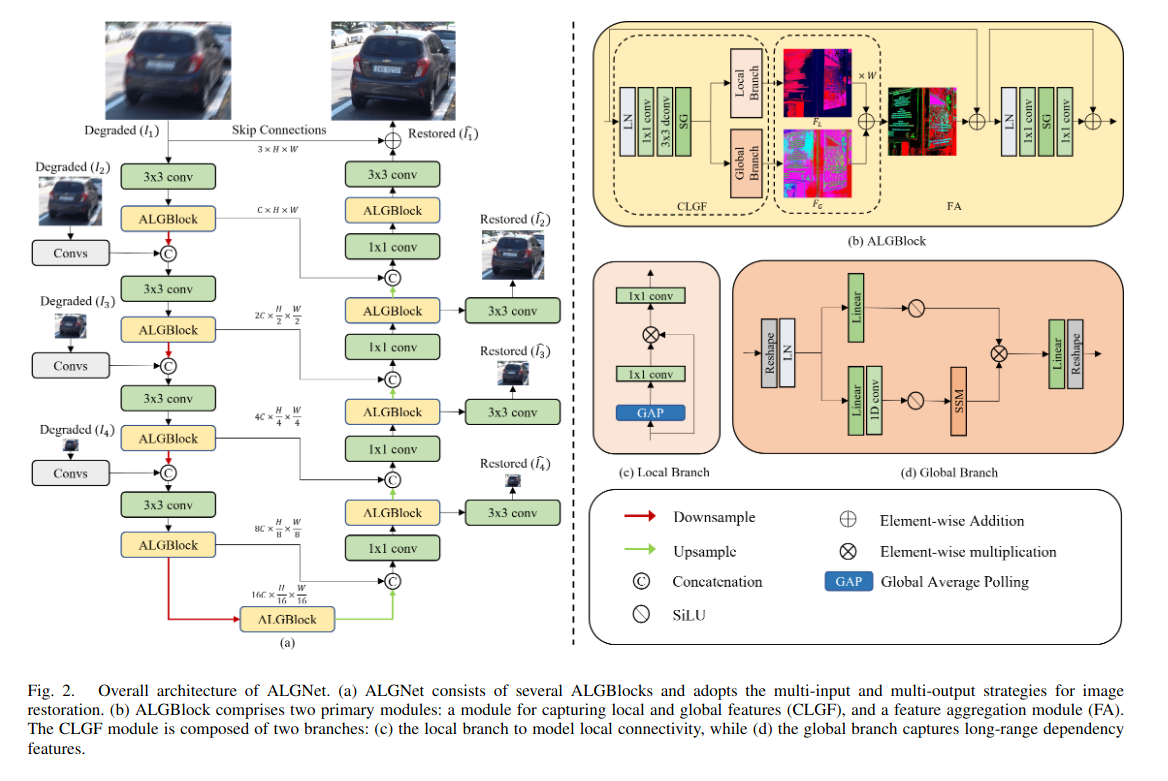

Больше всего трудностей вызвала реализация `Global branch`, в частности из-за того, что в оригинальной статье авторы не конкретизируют смысл и детали частей, представленных на схеме. 

Модифицированная схема содержит больше информации о реализации: 

![model](./model_new2.png)

`SSM` (state space model) представляет из себя блок, изпользующий идеи [теории управления](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B9_(%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D1%83%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)). Если говорить в общем плане, то основая идея заключается в том, что система моделируется с помощью некоторых "скрытых состояний", которые на деле являются обучаемыми параметрами в нескольких матрицах. Далее по формулам с помощью этих матриц вычисляется ядро свертки, которое применяется к видоизменённому тензору входной картинки. 

На вход поступает тензор формы `[B, C, L]`, где `C` - каналы, `L` в данной реализации равен `H*W`.

Из [работы](https://hazyresearch.stanford.edu/blog/2022-01-14-s4-3) было взято решение сделать `timescale parameter` также обучаемым параметром. 

Само получение одномерного ядра представляет собой конкатенирование результатов последовательных перемножений матриц, дающих одно число в виду размеров матриц.

![ssm](./ssm2.png)

In [ ]:
class SSM(nn.Module):
    def __init__(self, channels, state_size=64, kernel_length=32):
        super().__init__()

        self.N = state_size
        self.channels = channels
        self.kernel_length = kernel_length

        self.A = nn.Parameter(torch.randn(channels, self.N, self.N) * 0.1)
        self.B = nn.Parameter(torch.randn(channels, self.N, 1) * 0.1)
        self.C = nn.Parameter(torch.randn(channels, 1, self.N) * 0.1)
        self.delta = nn.Parameter(torch.randn(channels, 1) * 0.1)

    def discretize(self):
        delta_A = self.delta.unsqueeze(-1) * self.A
        delta_B = self.delta.unsqueeze(-1) * self.B

        I = torch.eye(self.N, device=self.A.device)
        I = I.unsqueeze(0)
        I = I.repeat(self.channels, 1, 1)

        discr_A = torch.linalg.matrix_exp(delta_A)
        discr_B = torch.linalg.solve(delta_A, torch.linalg.matrix_exp(delta_A - I) @ delta_B)
        discr_B = discr_B.to(self.A.device)
        
        return discr_A, discr_B

    def compute_kernel(self):
        with torch.autocast(device_type="cuda", enabled=False):
            discr_A, discr_B = self.discretize()
            kernels = []

            I = torch.eye(self.N, device=self.A.device)
            I = I.unsqueeze(0)
            I = I.repeat(self.channels, 1, 1)

            A_power = I
            for k in range(self.kernel_length):
                current_kernel = self.C @ (A_power @ discr_B)
                kernels.append(current_kernel.squeeze(-1))
                A_power = A_power @ discr_A

            discr_K = torch.stack(kernels, dim=-1)

        return discr_K

    def forward(self, x):
        discr_K = self.compute_kernel()
        _, _, L = x.size()
        
        x = F.conv1d(x,
                     discr_K,
                     padding=discr_K.size(-1) - 1,
                     groups=self.channels)

        x = x[..., :L]
        return x


В `Global branch` блоки `Linear` выполняют, по сути, функцию свертки с размером ядра 1. Входные картинки преобразуются из обычной формы `[B, C, H, W]` в `[B, H*W, C]` перед заходом в `Linear`, а те в свою очередь линейно комбинируют информацию вдоль всех каналов попиксельно и получают на выходе также `[B, H*W, C]`. Далее в нижней ветке происходит переворот в `[B, C, H*W]` для дальнейшей передачи в блок `SSM`. Затем опять преобразования и возврат результата.

Этот блок предназначен для агрегации мелких признаков.

In [ ]:
from utils import LayerNorm2d

class GlobalBranch(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.layer_normalisator = LayerNorm2d(channels)
        self.linear_up_branch = nn.Linear(channels, channels)
        self.linear_down_branch = nn.Linear(channels, channels)
        self.linear_output = nn.Linear(channels, channels)
        self.conv1d_down_branch = nn.Conv1d(channels, channels, 1)
        self.silu = nn.SiLU()
        self.SMM = SSM(channels, kernel_length=channels // 4)

    def forward(self, x):
        B, C, H, W = x.size() 

        x = self.layer_normalisator(x) # [B, C, H, W]

        x = x.permute(0, 2, 3, 1) # [B, H, W, C]
        x = x.reshape(B, H * W, C) # [B, H*W, C]
        
        up_branch = self.linear_up_branch(x)
        up_branch = self.silu(up_branch)

        down_branch = self.linear_down_branch(x)
        down_branch = down_branch.permute(0, 2, 1) # [B, C, H*W]
        down_branch = self.conv1d_down_branch(down_branch)
        down_branch = self.silu(down_branch)
        down_branch = self.SMM(down_branch)
        down_branch = down_branch.permute(0, 2, 1) # [B, H*W, C]

        x = up_branch * down_branch
        x = self.linear_output(x)
        
        x = x.permute(0, 2, 1) # [B, C, H*W]
        x = x.reshape(B, C, H, W) # [B, C, H, W]

        return x

`Local branch` реализован в точности со схемой. Целью является сбор общих признаков.

In [ ]:
class LocalBranch(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.GAP = nn.AdaptiveAvgPool2d(1)
        self.first_conv = nn.Conv2d(channels, channels, 1)
        self.second_conv = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        inp = x

        x = self.GAP(x)
        x = self.first_conv(x)
        x = x * inp
        x = self.second_conv(x)
        
        return x

`SLGF` берёт во внимание результаты работы `Local branch` и `Global branch`, дополнительно умножая результат `Local branch` на матрицу весов `W`. 

Помимо всего, здесь используется `SimpleGate`, реализованный при написании `NAFNet`.

In [ ]:
class CLGF(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.layer_normalisator = LayerNorm2d(channels)
        self.first_conv = nn.Conv2d(channels, channels, 1)
        self.depthwise_conv = nn.Conv2d(channels, 2*channels, 3, groups=channels, padding=1)
        self.SG = SimpleGate()
        self.local_branch = LocalBranch(channels)
        self.global_branch = GlobalBranch(channels)
        self.W = nn.Parameter(torch.randn(1, channels, 1, 1) * 0.1)

    def forward(self, x):
        x = self.layer_normalisator(x)
        x = self.first_conv(x)
        x = self.depthwise_conv(x)
        x = self.SG(x)

        local_branch = self.local_branch(x)
        global_branch = self.global_branch(x)

        return local_branch * self.W + global_branch

И сам `ALGBlock`

In [ ]:
class ALGBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.CLGF = CLGF(channels)
        self.layer_normalisator = LayerNorm2d(channels)
        self.first_conv = nn.Conv2d(channels, 2* channels, 1)
        self.SG = SimpleGate()
        self.second_conv = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        inp = x

        x = self.CLGF(x)
        x = x + inp
        temp = x

        x = self.layer_normalisator(x)
        x = self.first_conv(x)
        x = self.SG(x)
        x = self.second_conv(x)

        return x + temp

Далее идёт код трёх моделей, которые нужно было реализовать в рамках задания: простую сверточную с нексолькими слоями, сеть с архитектурой UNet и NAFNet. Также код функции обучения и функции ошибки

In [ ]:
# GRADED CELL: train_model
from skimage.metrics import mean_squared_error as mse

def train_model(model, train_dataloader, optimizer, criterion, scheduler, 
                num_epochs=200, checkpoints_path="./checkpoints", 
                use_grad_clip=True, save_checkpoints=True, load_last_checkpoint=True,
                save_epoch=1):
# Создаем папку для чекпоинтов
    if save_checkpoints:
        PATH = checkpoints_path
        SAVE_EPOCH = save_epoch  
        os.makedirs(PATH, exist_ok = True)
        
    last_epoch = -1
    last_dict = None
    if load_last_checkpoint:
        for file_name in tqdm(list(os.listdir(PATH))):
            try:
                cur_dict = torch.load(os.path.join(PATH, file_name), map_location=torch.device('cpu'))
                if cur_dict['epoch'] > last_epoch:
                    last_epoch = cur_dict['epoch']
                    if last_dict is not None:
                        del last_dict
                        
                    last_dict = cur_dict
                else:
                    del cur_dict
            except:
                pass
            
        if last_dict is not None:
            model.load_state_dict(last_dict['model_state_dict'])
            optimizer.load_state_dict(last_dict['optimizer_state_dict'])
            scheduler.load_state_dict(last_dict['scheduler_state_dict'])
            last_epoch = last_dict['epoch']
            print(f'Загружен последний чекпоинт из эпохи {last_epoch}')
            del last_dict
    
    print("last_epoch:", last_epoch)

    # Цикл обучения
    for epoch in range(last_epoch + 1, num_epochs):
        total_loss = 0.0
        total_samples = 0 

        PSNRs = []

        for inputs, targets in tqdm(train_dataloader, desc=f'Эпоха {epoch}'):
            # Your code vvv

            inputs = inputs.to(device)  
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            
            if use_grad_clip:
                # Здесь нужно реализовать ограничение градиентов
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                pass

            optimizer.step()
            
            # Your code ^^^
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        avg_loss = total_loss / total_samples
        # Сохраняем чекпоинт каждые SAVE_EPOCH эпох
        if save_checkpoints and epoch % SAVE_EPOCH == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    }, os.path.join(PATH, f"epoch_{epoch}.pth"))
    
        # Обновляем learning rate
        scheduler.step()
        print(f'Эпоха {epoch}, Loss: {avg_loss} LR: {scheduler.get_last_lr()[0]} Mean MSE: {np.mean(PSNRs)}')

In [ ]:
# GRADED CELL: Baseline
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBnBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Простой сверточный блок
        
        Ваша задача - реализовать следующие модули:

            conv + bn + relu
        
        """
        super().__init__()

        # Your code vvv
        
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1, padding_mode="reflect")
        self.normalisator = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        # Your code ^^^

    def forward(self, x):
        # Your code vvv

        convoluted = self.conv(x)
        normalised = self.normalisator(convoluted)
        relued = self.relu(normalised)

        return relued

        # Your code ^^^


class Baseline(nn.Module):
    def __init__(self, block, n_blocks=5, n_filters=64):
        """Базовая сверточная модель
        
        Ваша задача - реализовать следующую архитектуру:

            входной слой свертки (3 -> n_filters)
            n_blocks слоев ConvBnBlock
            выходной слой свертки (n_filters -> 3)
        
        """

        super().__init__()
        # Your code vvv
    
        self.input_conv = nn.Conv2d(3, n_filters, 3, padding=1, padding_mode="reflect")
        self.inner_convs = []

        for _ in range(n_blocks):
            self.inner_convs.append(block(n_filters, n_filters))

        self.inner_convs = nn.ModuleList(self.inner_convs)

        self.output_conv = nn.Conv2d(n_filters, 3, 3, padding=1, padding_mode="reflect")

        # Your code ^^^
        
    def forward(self, x):
        inp = x
        # Your code vvv

        tensor = self.input_conv(x)
        
        for i in range(len(self.inner_convs)):
            tensor = self.inner_convs[i](tensor)

        x = self.output_conv(tensor)

        # Your code ^^^
        return inp + x

In [ ]:
# GRADED CELL: PSNRLoss
class PSNRLoss(nn.Module):
    def __init__(self):
        """Функция потерь Peak signal-to-noise ratio
        
        ПРИМЕЧАНИЕ: во время обучения мы минимизируем функцию потерь, но большее значение PSNR означает лучшее качество
        Поэтому вы можете внести -1 в логарифм при реализации,
        тем самым избавившись от необходимости деления
        """
        super().__init__()
        self.eps = 1e-8  # используем eps чтобы избежать 0 в логарифме

    def forward(self, pred, target):
        """
            Реализуйте следующее вычисление:

                10 * mean(log10(mse(pred, target)))

        """
        # Your code vvv
        
        mse = torch.mean((pred - target) ** 2)
        if mse < self.eps:
            mse = self.eps

        return 10 * torch.mean(torch.log10(mse))

        # Your code ^^^

In [ ]:
# GRADED CELL: UNetBlock
class UNetBlock(nn.Module):
    def __init__(self, in_channels):
        """Базовый блок архитектуры UNet
        
        Ваша задача - реализовать следующие модули:

            conv + bn + relu + conv + bn + relu
            
        """
        super().__init__()
        # Your code vvv
        
        self.first_normalisator = nn.BatchNorm2d(num_features=in_channels)
        self.second_normalisator = nn.BatchNorm2d(num_features=in_channels)
        self.relu = F.relu
        self.first_conv = nn.Conv2d(in_channels, in_channels, 3, padding=1, padding_mode="reflect")
        self.second_conv = nn.Conv2d(in_channels, in_channels, 3, padding=1, padding_mode="reflect")

        # Your code ^^^
        
    def forward(self, x):
        # Your code vvv
        
        x = self.first_conv(x)
        x = self.first_normalisator(x)
        x = self.relu(x)

        x = self.second_conv(x)
        x = self.second_normalisator(x)
        x = self.relu(x)

        return x

        # Your code ^^^

In [ ]:
# GRADED CELL: UNetDownBlock
class UNetDownBlock(nn.Module):
    def __init__(self, chan):
        """Блок понижающей дискретизации (downsampling) в энкодере UNet

            Ваша задача - реализовать следующие модули:
            
                AvgPool + Conv 1x1

            Пространственная размерность входа **уменьшается** в 2 раза  
            Количество каналов **увеличивается** в 2 раза
        """
        super().__init__()
        # Your code vvv
        
        self.pooling = nn.AvgPool2d(kernel_size=2)
        self.conv = nn.Conv2d(chan, chan * 2, 1)

        # Your code ^^^
    
    def forward(self, x):
        # Your code vvv
        
        x = self.pooling(x)
        result = self.conv(x)

        return result

        # Your code ^^^

In [ ]:
# GRADED CELL: UNetUpBlock
class UNetUpBlock(nn.Module):
    def __init__(self, chan):
        """Блок повышающей дискретизации (upsampling) в декодере UNet

            Ваша задача - реализовать следующие модули:
            
                Upsample + Conv 1x1

            Пространственная размерность входа **увеличивается** в 2 раза  
            Количество каналов **уменьшается** в 2 раза
        """
        super().__init__()
        # Your code vvv
        
        self.upsampling = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(chan, chan // 2, 1)

        # Your code ^^^
    
    def forward(self, x):
        # Your code vvv
        
        x = self.upsampling(x)
        result = self.conv(x)

        return result

        # Your code ^^^

In [ ]:
# GRADED CELL: GeneralizedUNet
class GeneralizedUNet(nn.Module):
    def __init__(self, block, downBlock, upBlock, img_channel=3, width=16, 
                 middle_blk_num=1, enc_blk_nums=[1,1,1,1], dec_blk_nums=[1,1,1,1]):
        """Обобщенная архитектура UNet
        
            Эта часть уже реализована за вас
            Но вы можете изменить ее при необходимости

        """
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1, bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1, bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                downBlock(chan)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[block(chan) for _ in range(middle_blk_num)]
            )
        
        for num in dec_blk_nums:
            self.ups.append(
                upBlock(chan)
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, x):
        activations = []
        
        # Your code vvv

        inp = x
        x = self.intro(x)

        for i in range(len(self.encoders)):
            x = self.encoders[i](x)
            activations.append(x)
            x = self.downs[i](x)

        x = self.middle_blks(x)

        for i in range(len(self.decoders)):
            x = self.ups[i](x)
            x += activations[len(self.encoders) - i - 1]
            x = self.decoders[i](x)

        x = self.ending(x)

        return inp + x

        # Your code ^^^

In [ ]:
# GRADED CELL: SimpleGate
class SimpleGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
            Разделить вход на 2 части вдоль оси каналов
            Вернуть произведение этих 2 частей
        """
        # Your code vvv
        
        first_chunk, second_chunk = torch.chunk(x, chunks=2, dim=1)
        return first_chunk * second_chunk

        # Your code ^^^

In [ ]:
# GRADED CELL: NAFNetUpBlock
class NAFNetUpBlock(nn.Module):
    def __init__(self, channels):
        """Блок повышающей дискретизации (upsampling) NAFNet
        
        Реализуйте и используйте следующие модули:

            свертка 1x1 (chan -> 2 * chan)
            pixelshuffle(2)
        
        """
        super().__init__()
        # Your code vvv
        
        self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)

        # Your code ^^^
        
    def forward(self, x):
        # Your code vvv
        
        x = self.conv(x)         
        x = self.pixel_shuffle(x) 
        return x
        
        # Your code ^^^

In [ ]:
# GRADED CELL: NAFNetDownBlock
class NAFNetDownBlock(nn.Module):
    def __init__(self, channels):
        """Блок понижающей дискретизации (downsampling) NAFNet
        
        Реализуйте и используйте следующие модули:
        
            свертка с шагом (stride) 2, **обратите внимание на padding**

        """
        super().__init__()
        # Your code vvv

        self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=3, stride=2, padding=1)

        # Your code ^^^

    def forward(self, x):
        # Your code vvv
        
        x = self.conv(x)
        return x

        # Your code ^^^

In [ ]:
# GRADED CELL: SCA
class SCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Упрощенный модуль channel attention
        
        Реализуйте и используйте следующие модули:
        
            adaptiveavgpool для получения карты признаков 1x1
            проекционный слой свертки 1x1
        
        """
        super().__init__()
        # Your code vvv
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # Your code ^^^
        
    def forward(self, x):
        """
            Вернуть только веса внимания (attention weights)

        """
        # Your code vvv
        
        x = self.avgpool(x)
        x = self.conv(x)
        return x

        # Your code ^^^

In [ ]:
# GRADED CELL: NAFNetBlock
from utils import LayerNorm2d  # use this layernorm

class NAFNetBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2):
        super().__init__()

        dw_channel = c * DW_Expand
        ffn_channel = FFN_Expand * c

        self.beta = nn.Parameter(torch.ones(1))
        self.gamma = nn.Parameter(torch.ones(1))

        # Your code vvv
        
        self.normalisator = LayerNorm2d(c)
        self.conv1 = nn.Conv2d(in_channels=c,
                               out_channels=dw_channel,
                               kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=dw_channel,
                               out_channels=dw_channel,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2,
                               out_channels=c,
                               kernel_size=1)
        self.conv4 = nn.Conv2d(in_channels=c,
                               out_channels=ffn_channel,
                               kernel_size=3,
                               padding=1)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2,
                               out_channels=c,
                               kernel_size=3,
                               padding=1)
        self.simple_gate = SimpleGate()
        self.SCA = SCA(dw_channel // 2, dw_channel // 2)

        # Your code ^^^

    def forward(self, x):
        # Your code vvv
        
        inp = x

        x = self.normalisator(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.simple_gate(x) 
        x = self.SCA(x) * x

        x = self.conv3(x)
        x *= self.beta

        x = self.normalisator(inp + x)
        x = self.conv4(x)
        x = self.simple_gate(x)
        x = self.conv5(x)
        x *= self.gamma

        return inp + x

        # Your code ^^^

In [ ]:
# GRADED CELL: get_my_cool_model
def get_my_cool_model(model_path=None, device=device):

    # GRADED CELL: GeneralizedUNet
    class GeneralizedUNet(nn.Module):
        def __init__(self, block, downBlock, upBlock, img_channel=3, width=16, 
                    middle_blk_num=1, enc_blk_nums=[1,1,1,1], dec_blk_nums=[1,1,1,1]):
            """Обобщенная архитектура UNet
            
                Эта часть уже реализована за вас
                Но вы можете изменить ее при необходимости

            """
            super().__init__()

            self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1, bias=True)
            self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1, bias=True)

            self.encoders = nn.ModuleList()
            self.decoders = nn.ModuleList()
            self.middle_blks = nn.ModuleList()
            self.ups = nn.ModuleList()
            self.downs = nn.ModuleList()

            chan = width
            
            for num in enc_blk_nums:
                self.encoders.append(
                    nn.Sequential(
                        *[block(chan) for _ in range(num)]
                    )
                )
                self.downs.append(
                    downBlock(chan)
                )
                chan = chan * 2

            self.middle_blks = \
                nn.Sequential(
                    *[block(chan) for _ in range(middle_blk_num)]
                )
            
            for num in dec_blk_nums:
                self.ups.append(
                    upBlock(chan)
                )
                chan = chan // 2
                self.decoders.append(
                    nn.Sequential(
                        *[block(chan) for _ in range(num)]
                    )
                )

            self.padder_size = 2 ** len(self.encoders)

        def forward(self, x):
            activations = []
            
            # Your code vvv


            inp = x
            x = self.intro(x)

            for i in range(len(self.encoders)):
                x = self.encoders[i](x)
                activations.append(x)
                x = self.downs[i](x)

            x = self.middle_blks(x)

            for i in range(len(self.decoders)):
                x = self.ups[i](x)
                x += activations[len(self.encoders) - i - 1]
                x = self.decoders[i](x)

            x = self.ending(x)

            return inp + x

            # Your code ^^^

    # GRADED CELL: SimpleGate
    class SimpleGate(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, x):
            """
                Разделить вход на 2 части вдоль оси каналов
                Вернуть произведение этих 2 частей
            """
            # Your code vvv
            
            first_chunk, second_chunk = torch.chunk(x, chunks=2, dim=1)
            return first_chunk * second_chunk

            # Your code ^^^
    # GRADED CELL: NAFNetUpBlock
    class NAFNetUpBlock(nn.Module):
        def __init__(self, channels):
            """Блок повышающей дискретизации (upsampling) NAFNet
            
            Реализуйте и используйте следующие модули:

                свертка 1x1 (chan -> 2 * chan)
                pixelshuffle(2)
            
            """
            super().__init__()
            # Your code vvv
            
            self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=1)
            self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)

            # Your code ^^^
            
        def forward(self, x):
            # Your code vvv
            
            x = self.conv(x)         
            x = self.pixel_shuffle(x) 
            return x
            
            # Your code ^^^

        # GRADED CELL: NAFNetDownBlock
    class NAFNetDownBlock(nn.Module):
        def __init__(self, channels):
            """Блок понижающей дискретизации (downsampling) NAFNet
            
            Реализуйте и используйте следующие модули:
            
                свертка с шагом (stride) 2, **обратите внимание на padding**

            """
            super().__init__()
            # Your code vvv

            self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=3, stride=2, padding=1)

            # Your code ^^^

        def forward(self, x):
            # Your code vvv
            
            x = self.conv(x)
            return x

            # Your code ^^^
    # GRADED CELL: SCA
    class SCA(nn.Module):
        def __init__(self, in_channels, out_channels):
            """Упрощенный модуль channel attention
            
            Реализуйте и используйте следующие модули:
            
                adaptiveavgpool для получения карты признаков 1x1
                проекционный слой свертки 1x1
            
            """
            super().__init__()
            # Your code vvv
            
            self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

            # Your code ^^^
            
        def forward(self, x):
            """
                Вернуть только веса внимания (attention weights)

            """
            # Your code vvv
            
            x = self.avgpool(x)
            x = self.conv(x)
            return x

            # Your code ^^^

    # GRADED CELL: NAFNetBlock
    from utils import LayerNorm2d  # use this layernorm

    class NAFNetBlock(nn.Module):
        def __init__(self, c, DW_Expand=2, FFN_Expand=2):
            super().__init__()

            dw_channel = c * DW_Expand
            ffn_channel = FFN_Expand * c

            self.beta = nn.Parameter(torch.ones(1))
            self.gamma = nn.Parameter(torch.ones(1))

            # Your code vvv
            
            self.normalisator = LayerNorm2d(c)
            self.conv1 = nn.Conv2d(in_channels=c,
                                out_channels=dw_channel,
                                kernel_size=1)
            self.conv2 = nn.Conv2d(in_channels=dw_channel,
                                out_channels=dw_channel,
                                kernel_size=3,
                                padding=1)
            self.conv3 = nn.Conv2d(in_channels=dw_channel // 2,
                                out_channels=c,
                                kernel_size=1)
            self.conv4 = nn.Conv2d(in_channels=c,
                                out_channels=ffn_channel,
                                kernel_size=3,
                                padding=1)
            self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2,
                                out_channels=c,
                                kernel_size=3,
                                padding=1)
            self.simple_gate = SimpleGate()
            self.SCA = SCA(dw_channel // 2, dw_channel // 2)

            # Your code ^^^

        def forward(self, x):
            # Your code vvv
            
            inp = x

            x = self.normalisator(x)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.simple_gate(x) 
            x = self.SCA(x) * x

            x = self.conv3(x)
            x *= self.beta

            x = self.normalisator(inp + x)
            x = self.conv4(x)
            x = self.simple_gate(x)
            x = self.conv5(x)
            x *= self.gamma

            return inp + x

        # Your code ^^^

    model = GeneralizedUNet(NAFNetBlock, 
                            NAFNetDownBlock, 
                            NAFNetUpBlock, 
                            enc_blk_nums=[1,2,2,28], 
                            dec_blk_nums=[2,2,2,1])
    
    if model_path is not None:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict']) # Пример загрузки модели из файла
    else:
        # Пример обучения модели
        model = model.to(device)

        criterion = PSNRLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        use_grad_clip = True
        scheduler = get_scheduler(optimizer)

        train_model(model, train_dataloader, optimizer, criterion, scheduler, checkpoints_path='./checkpoints/my_cool_model', use_grad_clip=use_grad_clip)
    # Your code ^^^
    return model.to(device)